In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
%pylab inline

from torch import nn, optim

from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpy as np
# import tensorflow_probability as tfp; tfp = tfp.substrates.jax
# tfd = tfp.distributions
# tfb = tfp.bijectors

import torch
import jaxlie
from gecco_torch.utils.isotropic_gaussian import IsotropicGaussianSO3
from gecco_torch.utils.isotropic_gaussian_no_vmap import IsotropicGaussianSO3 as IsotropicGaussianSO3_no_vmap
from gecco_torch.utils.isotropic_plotting import visualize_so3_probabilities
import lietorch

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/jaxtyping/__init__.py:243: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


## Create test distribution

In [3]:
@jax.jit
@jax.vmap
def sample_checkerboard(seed, size=np.pi):
    key1, key2, key3 = jax.random.split(seed, 3)
    x1 = jax.random.uniform(key=key1) * size - size/2
    x2_ = jax.random.uniform(key=key2) - jax.random.randint(minval=0, maxval=2,shape=[], key=key3) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)
    data = jnp.stack([x1, x2]) * size/2
    Rs = jaxlie.SO3.from_rpy_radians(pitch=data[0]/2, yaw=data[1], roll=0).as_matrix()
    return Rs

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


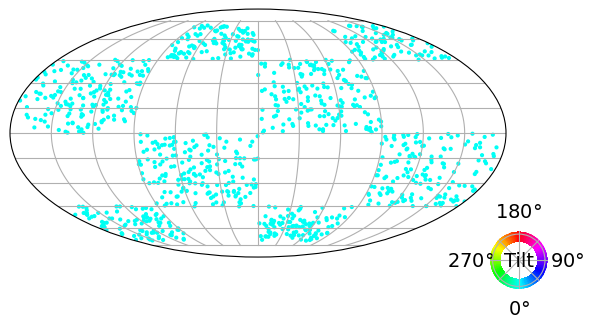

In [4]:
# Create a checkerboard grid
Rs = sample_checkerboard(jax.random.split(jax.random.PRNGKey(0), 1024))
visualize_so3_probabilities(
    Rs,
    0.001);

## Create the noisy dataset

In [5]:
# This will decide our noise schedule, to start with, here I use a linear noise schedule in 
# variance, based on the Variance Exploding SDE (note, slightly diffrent from the choices of Ho et al.)
# This is not necessarily the best choice, this is just for testing
delta = 0.01 # delta in noise variance
noise_schedule = jnp.arange(0.01,0.9, delta) # Noise variance

In [6]:
def sample(R, scale):
    # r shape 512,3,3
    rots = torch.zeros((R.shape[0],4))
    for i in range(R.shape[0]):
        x = jaxlie.SO3.from_matrix(R[i])
        x = torch.from_numpy(np.array(x.wxyz))

        # von der jax wxyz darstellung zur lietorch xyzw darstellung
        x = x[[1,2,3,0]]
        rots[i] = x
    
    # print(f"rotations x shape {rots.shape}")
    # x = lietorch.SO3.InitFromVec(rots)
    # print(x)
    # print(f"scale shape {scale.val.shape}")
    # Sampling from current temperature
    dist = IsotropicGaussianSO3(rots, scale)
    qn = dist.sample()

    # zurück zur wxyz darstellung
    # qn_wxyz = qn[:,[3,0,1,2]]

    
    # Sampling from next temperature step 
    scale_torch = torch.sqrt(delta * torch.ones(R.shape[0],device=qn.device))
    dist2 = IsotropicGaussianSO3(qn, scale_torch)
    qnplus1 = dist2.sample()

    # zurück zur wxyz darstellung
    # qnplus1_wxyz = qnplus1[:,[3,0,1,2]]
    
    # zurück zur wxyz darstellung
    # x_wxyz = x.vec()[:,[3,0,1,2]]

    res = {'x': rots, 'yn': qn, 'yn+1': qnplus1,
            'sn':scale, 'sn+1':torch.sqrt(scale**2 + delta)}
    return res

def get_batch(seed, batch_size=512):
    key1, key2, key3 = jax.random.split(seed,3)
    # Sample from the target distribution
    Rs = sample_checkerboard(jax.random.split(key1, batch_size))
    # Rs = torch.from_numpy(np.array(Rs))
    
    # Sample random noise levels from the schedule
    s = jax.random.choice(key3, noise_schedule, shape=[batch_size])
    s = torch.from_numpy(np.array(s)).sqrt()
    
    # Sample random rotations
    samp = sample(Rs, s)
    # samp['yn'] = samp['yn'][-1]
    # samp['yn+1'] = samp['yn+1'][-1]
    # samp['x'] = samp['x'][-1]
    return samp

## Aus Spaß mal schauen, wie eine Normalverteilung als rotationen aussieht

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


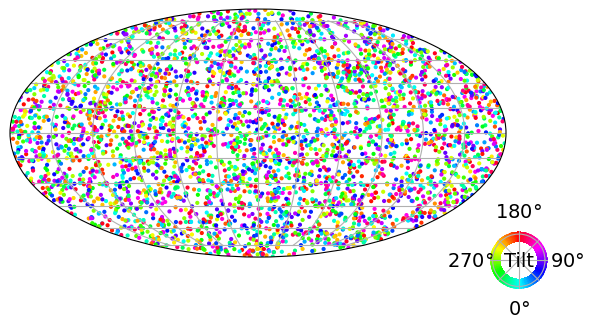

In [7]:
normal_rotations = torch.randn(4000, 4)
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in normal_rotations]),
    0.001
)

In [16]:
unit_rotations = torch.zeros((1, 4))
unit_rotations[:,3] = 1
rotation_distribution = IsotropicGaussianSO3_no_vmap(unit_rotations, 100*torch.ones(4000).reshape(-1,1), force_small_scale=False)
log_p_rot = normal_rotations.cuda()
log_p_rot = log_p_rot / log_p_rot.norm(dim=-1, keepdim=True)
valid_rots = lietorch.SO3.exp(normal_rotations).cuda()
print(rotation_distribution.log_prob(unit_rotations.cuda()))
print(rotation_distribution.log_prob(unit_rotations.cuda()).shape)

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
torch.Size([4000])


/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian_no_vmap.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
batch = get_batch(jax.random.PRNGKey(0))

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


RuntimeError: The size of tensor a (512) must match the size of tensor b (1024) at non-singleton dimension 1

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


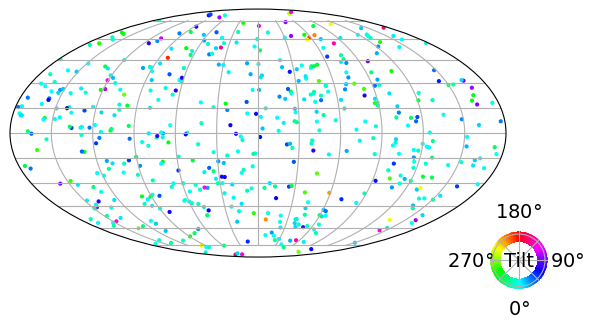

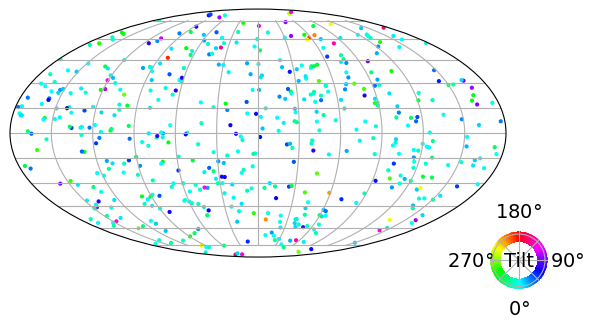

In [ ]:
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in batch['yn']]),
    0.001
    )

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


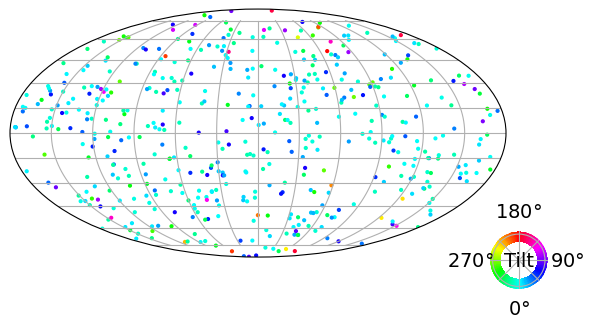

In [ ]:
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in batch['yn+1']]),
    0.001);

## Train a Denoising Diffusion Model without Analytical Solution

In [ ]:

class SimpleMLP(nn.Module):
    def __init__(self,input_size=5):
        super(SimpleMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
        )
        self.layer_mu = nn.Linear(256, 4)
        self.layer_scale = nn.Linear(256, 1)

    def forward(self, x, s):
        concat = torch.cat([x, s], dim=-1)
        out = self.mlp(concat)
        mu = self.layer_mu(out) + x
        mu = mu / torch.norm(mu, dim=-1, keepdim=True)

        scale = self.layer_scale(out)
        scale = nn.functional.softplus(scale) + 0.001
        return mu, scale

In [ ]:
import haiku as hk

# Create a random sequence
model = SimpleMLP().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
rng_seq = hk.PRNGSequence(42)
losses = []


In [ ]:
def train(model, batch):
    model.train()
    optimizer.zero_grad()
    # yn1 = torch.from_numpy(np.array(batch['yn+1']))
    # sn1 = torch.from_numpy(np.array(batch['sn+1']))
    yn1 = batch['yn+1'].cuda()
    sn1 = batch['sn+1'].cuda()

    mu, scale = model(yn1, sn1.reshape(-1,1))

    def fn(x, mu, scale):

        # von der wxyz zur lietorch xyzw darstellung
        # mu = mu[:,[1,2,3,0]]
        dist = IsotropicGaussianSO3(mu, scale, 
                                    force_small_scale=True)

        # logprob auch in der lietorch xyzw darstellung
        # prob_dist = dist.log_prob(x[:,[1,2,3,0]]) 
        prob_dist = dist.log_prob(x) 
        return prob_dist # shape 512
    
    yn = batch['yn']
    loss = (-fn(yn, mu, scale)).mean()
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
for step in tqdm(range(1000)):
    batch = get_batch(seed=next(rng_seq))
    loss = train(model, batch)
    if step % 10 == 0:
        print(loss)
    losses.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
  0%|          | 1/1000 [00:00<08:33,  1.95it/s]

-2.6230087280273438


  1%|          | 11/1000 [00:03<05:34,  2.95it/s]

-2.6343436241149902


  2%|▏         | 21/1000 [00:07<05:37,  2.90it/s]

-2.791489601135254


  3%|▎         | 31/1000 [00:10<05:25,  2.97it/s]

-2.8620002269744873


  4%|▍         | 41/1000 [00:14<05:22,  2.97it/s]

-2.9819202423095703


  5%|▌         | 51/1000 [00:17<05:19,  2.97it/s]

-3.091423988342285


  6%|▌         | 61/1000 [00:20<05:15,  2.98it/s]

-3.1938984394073486


  7%|▋         | 71/1000 [00:24<05:13,  2.97it/s]

-3.3354415893554688


  8%|▊         | 81/1000 [00:27<05:08,  2.98it/s]

-3.5116562843322754


  9%|▉         | 91/1000 [00:30<05:05,  2.98it/s]

-3.7117834091186523


 10%|█         | 101/1000 [00:34<05:02,  2.97it/s]

-3.794813871383667


 11%|█         | 111/1000 [00:37<05:00,  2.95it/s]

-4.169248580932617


 12%|█▏        | 121/1000 [00:40<04:57,  2.96it/s]

-4.524903297424316


 13%|█▎        | 131/1000 [00:44<04:53,  2.97it/s]

-4.90606164932251


 14%|█▍        | 141/1000 [00:47<04:48,  2.98it/s]

-2.6569619178771973


 15%|█▌        | 151/1000 [00:51<04:47,  2.95it/s]

-5.530612468719482


 16%|█▌        | 161/1000 [00:54<04:42,  2.97it/s]

-5.818352699279785


 17%|█▋        | 171/1000 [00:57<04:39,  2.97it/s]

-5.649256229400635


 18%|█▊        | 181/1000 [01:01<04:34,  2.98it/s]

-4.131492614746094


 19%|█▉        | 191/1000 [01:04<04:35,  2.94it/s]

-5.349153995513916


 20%|██        | 201/1000 [01:07<04:28,  2.97it/s]

-5.106890678405762


 21%|██        | 211/1000 [01:11<04:24,  2.98it/s]

-5.173636436462402


 22%|██▏       | 221/1000 [01:14<04:21,  2.98it/s]

-5.088052749633789


 23%|██▎       | 231/1000 [01:17<04:18,  2.97it/s]

-5.163980484008789


 24%|██▍       | 241/1000 [01:21<04:16,  2.96it/s]

-5.199207305908203


 25%|██▌       | 251/1000 [01:24<04:12,  2.96it/s]

-5.0428948402404785


 26%|██▌       | 261/1000 [01:28<04:07,  2.98it/s]

-5.281573295593262


 27%|██▋       | 271/1000 [01:31<04:07,  2.94it/s]

-5.331207752227783


 28%|██▊       | 281/1000 [01:34<04:01,  2.97it/s]

-5.113814830780029


 29%|██▉       | 291/1000 [01:38<03:57,  2.98it/s]

-5.506836414337158


 30%|███       | 301/1000 [01:41<03:58,  2.93it/s]

-5.477524757385254


 31%|███       | 311/1000 [01:45<03:52,  2.96it/s]

-4.945284366607666


 32%|███▏      | 321/1000 [01:48<03:47,  2.98it/s]

-4.11102819442749


 33%|███▎      | 331/1000 [01:51<03:45,  2.97it/s]

-5.7497663497924805


 34%|███▍      | 341/1000 [01:55<03:41,  2.98it/s]

-5.540468215942383


 35%|███▌      | 351/1000 [01:58<03:39,  2.95it/s]

-5.739528656005859


 36%|███▌      | 361/1000 [02:01<03:38,  2.93it/s]

-5.146787643432617


 37%|███▋      | 371/1000 [02:05<03:31,  2.97it/s]

-5.573386192321777


 38%|███▊      | 381/1000 [02:08<03:31,  2.92it/s]

-5.645139694213867


 39%|███▉      | 391/1000 [02:12<03:26,  2.95it/s]

8.143575668334961


 40%|████      | 401/1000 [02:15<03:25,  2.91it/s]

-5.165716171264648


 41%|████      | 411/1000 [02:18<03:20,  2.94it/s]

-5.209599494934082


 42%|████▏     | 421/1000 [02:22<03:14,  2.97it/s]

-5.322261810302734


 43%|████▎     | 431/1000 [02:25<03:11,  2.97it/s]

-5.174036026000977


 44%|████▍     | 441/1000 [02:29<03:17,  2.83it/s]

-5.696315765380859


 45%|████▌     | 451/1000 [02:32<03:03,  2.99it/s]

-4.245810508728027


 46%|████▌     | 461/1000 [02:35<03:00,  2.98it/s]

-5.578152656555176


 47%|████▋     | 471/1000 [02:39<02:57,  2.98it/s]

0.9858507513999939


 48%|████▊     | 481/1000 [02:42<02:54,  2.98it/s]

-4.657986164093018


 49%|████▉     | 491/1000 [02:46<02:50,  2.98it/s]

-5.555582046508789


 50%|█████     | 501/1000 [02:49<02:49,  2.94it/s]

-5.669877052307129


 51%|█████     | 511/1000 [02:52<02:50,  2.87it/s]

-5.915392875671387


 52%|█████▏    | 521/1000 [02:56<02:50,  2.80it/s]

-6.017631530761719


 53%|█████▎    | 531/1000 [02:59<02:41,  2.90it/s]

-5.868147373199463


 54%|█████▍    | 541/1000 [03:03<02:39,  2.88it/s]

-5.920285701751709


 55%|█████▌    | 551/1000 [03:06<02:33,  2.93it/s]

0.29161423444747925


 56%|█████▌    | 561/1000 [03:10<02:29,  2.93it/s]

8.09541130065918


 57%|█████▋    | 571/1000 [03:13<02:24,  2.96it/s]

-5.619865417480469


 58%|█████▊    | 581/1000 [03:16<02:20,  2.98it/s]

-5.753568649291992


 59%|█████▉    | 591/1000 [03:20<02:17,  2.98it/s]

-4.949336051940918


 60%|██████    | 601/1000 [03:23<02:13,  2.99it/s]

-5.870504856109619


 61%|██████    | 611/1000 [03:26<02:12,  2.95it/s]

-5.654401779174805


 62%|██████▏   | 621/1000 [03:30<02:11,  2.89it/s]

-5.81201171875


 63%|██████▎   | 631/1000 [03:33<02:08,  2.87it/s]

-5.945455074310303


 64%|██████▍   | 641/1000 [03:37<02:00,  2.97it/s]

-5.400343894958496


 65%|██████▌   | 651/1000 [03:40<01:58,  2.94it/s]

-4.038149833679199


 66%|██████▌   | 661/1000 [03:43<01:54,  2.97it/s]

-6.042222023010254


 67%|██████▋   | 671/1000 [03:47<01:52,  2.94it/s]

-5.75541353225708


 68%|██████▊   | 681/1000 [03:50<01:48,  2.95it/s]

-5.801568984985352


 69%|██████▉   | 691/1000 [03:54<01:46,  2.90it/s]

-5.900454044342041


 70%|███████   | 701/1000 [03:57<01:45,  2.84it/s]

-5.955260276794434


 71%|███████   | 711/1000 [04:01<01:37,  2.97it/s]

-5.841113090515137


 72%|███████▏  | 721/1000 [04:04<01:35,  2.91it/s]

1.9076788425445557


 73%|███████▎  | 731/1000 [04:07<01:30,  2.97it/s]

-4.269368648529053


 74%|███████▍  | 741/1000 [04:11<01:27,  2.96it/s]

-5.773838996887207


 75%|███████▌  | 751/1000 [04:14<01:24,  2.95it/s]

-4.237536907196045


 76%|███████▌  | 761/1000 [04:18<01:20,  2.96it/s]

-5.680312633514404


 77%|███████▋  | 771/1000 [04:21<01:18,  2.92it/s]

-5.337184906005859


 78%|███████▊  | 781/1000 [04:24<01:16,  2.86it/s]

-5.508013725280762


 79%|███████▉  | 791/1000 [04:28<01:12,  2.90it/s]

-5.755255699157715


 80%|████████  | 801/1000 [04:31<01:10,  2.83it/s]

-5.9941182136535645


 81%|████████  | 811/1000 [04:35<01:03,  2.97it/s]

-5.947079181671143


 82%|████████▏ | 821/1000 [04:38<01:00,  2.96it/s]

-5.671047210693359


 83%|████████▎ | 831/1000 [04:42<01:00,  2.80it/s]

-5.933775901794434


 84%|████████▍ | 841/1000 [04:45<00:53,  2.97it/s]

-5.951484680175781


 85%|████████▌ | 851/1000 [04:48<00:50,  2.95it/s]

-5.735577583312988


 86%|████████▌ | 861/1000 [04:52<00:46,  2.98it/s]

-6.133490085601807


 87%|████████▋ | 871/1000 [04:55<00:43,  2.98it/s]

-6.217573165893555


 88%|████████▊ | 881/1000 [04:59<00:39,  2.98it/s]

-6.172702789306641


 89%|████████▉ | 891/1000 [05:02<00:36,  2.96it/s]

7.944185733795166


 90%|█████████ | 901/1000 [05:05<00:33,  2.96it/s]

-5.678154468536377


 91%|█████████ | 911/1000 [05:09<00:30,  2.97it/s]

-3.910186767578125


 92%|█████████▏| 921/1000 [05:12<00:26,  2.96it/s]

-6.1380205154418945


 93%|█████████▎| 931/1000 [05:16<00:24,  2.86it/s]

-6.054358959197998


 94%|█████████▍| 941/1000 [05:19<00:19,  2.98it/s]

-3.315497875213623


 95%|█████████▌| 951/1000 [05:22<00:16,  2.95it/s]

-5.3961710929870605


 96%|█████████▌| 961/1000 [05:26<00:13,  2.97it/s]

-6.078002452850342


 97%|█████████▋| 971/1000 [05:29<00:09,  2.98it/s]

-6.411141395568848


 98%|█████████▊| 981/1000 [05:32<00:06,  2.98it/s]

-6.107226371765137


 99%|█████████▉| 991/1000 [05:36<00:03,  2.97it/s]

-5.973550796508789


100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


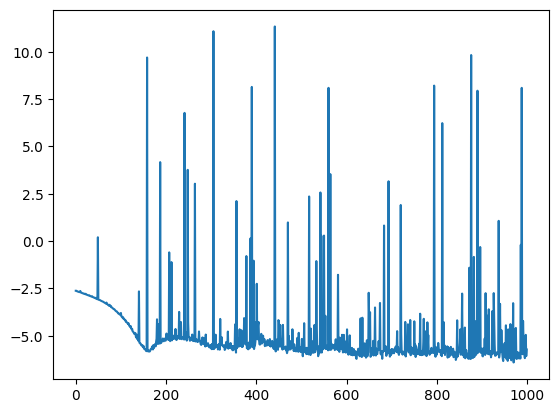

In [ ]:
plot(losses)

## Sampling from the model

Note that here, this is only a small test, starting from a noised version of the target distribution, not uniform noise

In [ ]:
# Try to sample with the trained model
nsamps = 10000
points = sample_checkerboard(jax.random.split(jax.random.PRNGKey(0), nsamps))
points = sample(points, torch.from_numpy(np.array(noise_schedule[-1])).sqrt()*torch.ones(nsamps))

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


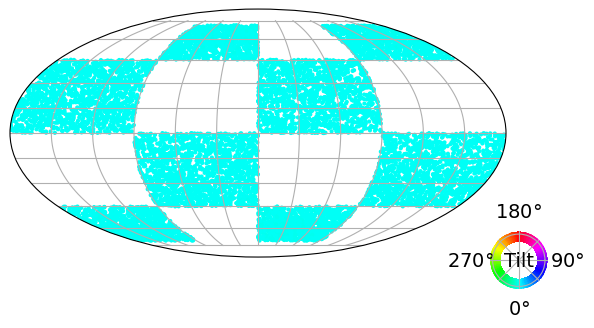

In [ ]:
# Target distribution -> Die die wir lernen wollen
import matplotlib.pyplot as plt
p = visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in points['x']]), 
    0.001);
p.savefig('target.png')

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


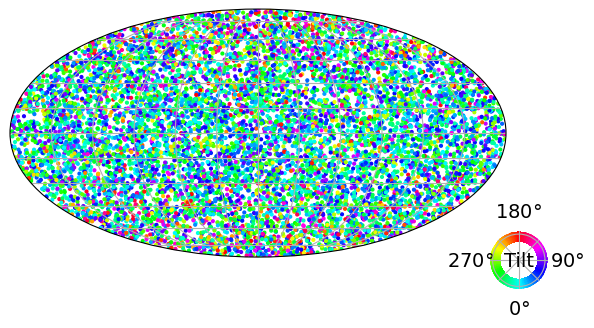

In [ ]:
# Samples at T=~1 # Nur noise
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in points['yn']]),
    0.001);

In [ ]:
def fn_sample(mu,s):
    ig = IsotropicGaussianSO3(mu, s, force_small_scale=True)
    samp = ig.sample()
    return samp

# Running the denoising loop
x = points['yn']
reverse_noise_schedule = torch.from_numpy(np.array(noise_schedule[::-1])).cuda()
with torch.no_grad():
    for i,variance in enumerate(reverse_noise_schedule):
        var = variance.sqrt() * torch.ones((nsamps,1),device=x.device)
        mu, s = model(x, var)
        print(f"{i}, mu shape {mu.shape}, s shape {s.shape}, {mu[0]}")
        x = fn_sample(mu, s)

0, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1421, -0.3944,  0.8277,  0.3730], device='cuda:0')
1, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1504, -0.3434,  0.8106,  0.4499], device='cuda:0')
2, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1928, -0.4209,  0.7524,  0.4686], device='cuda:0')
3, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2199, -0.4153,  0.7366,  0.4863], device='cuda:0')
4, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1555, -0.4521,  0.7002,  0.5303], device='cuda:0')
5, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1848, -0.3971,  0.7195,  0.5390], device='cuda:0')
6, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2108, -0.4118,  0.6988,  0.5456], device='cuda:0')
7, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2146, -0.35

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


16, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2876, -0.3199,  0.7665,  0.4768], device='cuda:0')
17, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2680, -0.3198,  0.7283,  0.5436], device='cuda:0')
18, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2849, -0.2707,  0.7203,  0.5717], device='cuda:0')
19, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.2242, -0.3228,  0.7487,  0.5339], device='cuda:0')
20, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1463, -0.3762,  0.6520,  0.6419], device='cuda:0')
21, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1271, -0.3490,  0.6646,  0.6484], device='cuda:0')
22, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.1650, -0.2655,  0.6929,  0.6498], device='cuda:0')
23, mu shape torch.Size([10000, 4]), s shape torch.Size([10000, 1]), tensor([ 0.172

In [ ]:
from gecco_torch.utils.isotropic_plotting import visualize_so3_density

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


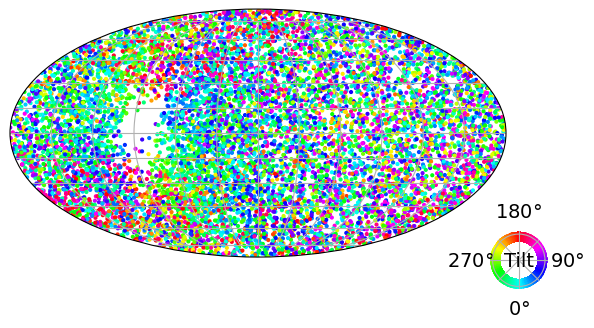

In [ ]:
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in x]),
    0.001);
# es lässt sich erkennen, dass das model ein bisschen das Schachbrett Muster gelernt hat. Die rotation, die durch die Farben gegeben ist, stimmt
# und einige Schachbrettfelder, die weiß sein müssten, sind ansatzweise weiß

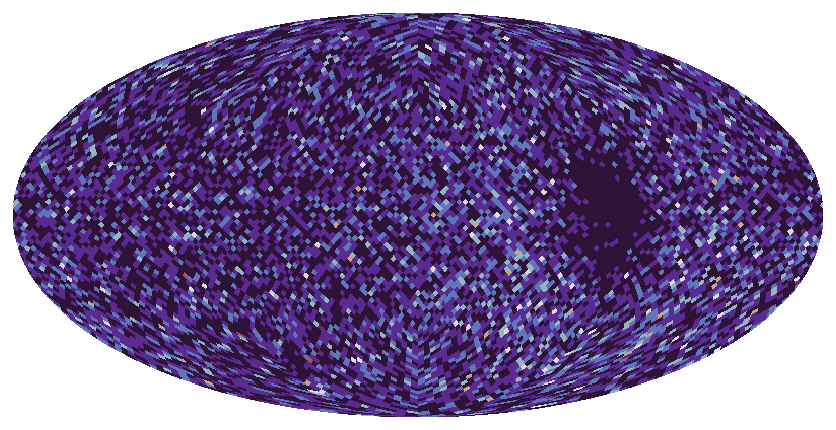

In [ ]:
visualize_so3_density(
    jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in x]),
    32);